# Spatial weights in PySAL

In this session, you will be learning the ins and outs of one of the key
pieces in spatial analysis: spatial weights matrices. These are
structured sets of numbers that formalise geographical relationships
between the observations in a dataset. Essentially, a spatial weights
matrix of a given geography is a positive definite matrix of dimensions
$N$ by $N$, where $N$ is the total number of observations:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0
\end{array} \right)
$$

where each cell $w_{ij}$ contains a value that represents the degree of
spatial contact or interaction between observations $i$ and $j$. A
fundamental concept in this context is that of *neighbour* and
*neighbourhood*. By convention, elements in the diagonal ($w_{ii}$) are
set to zero. A *neighbour* of a given observation $i$ is another
observation with which $i$ has some degree of connection. In terms of
$W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this
logic, the neighbourhood of $i$ will be the set of observations in the
system with which it has a certain connection or those observations with
a weight greater than zero.

There are several ways to create such matrices and many more to
transform them so they contain an accurate representation that aligns
with the way you understand spatial interactions between the elements of
a system. This session will introduce the most commonly used ones and
show how to compute them with `PySAL`.

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

from libpysal import graph


## Data

For this tutorial, you will use a dataset of Basic Settlement Units
(ZSJ) in Prague for 2021. The table is available as part of this course,
so it can be accessed remotely through the web. If you want to see how
the table was created, a notebook is available
[here](../data/prague_zsj_2021/preprocessing.ipynb).

To make things easier, you will read data from a file posted online so,
for now, you do not need to download any dataset:

In [2]:
prague = gpd.read_file(
    "https://martinfleischmann.net/sds/chapter_04/data/zsj_prague_2021.gpkg"
)
prague = prague.set_index("NAZ_ZSJ")
prague.explore()


Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_48dcb4f270e54f39e73111b24b959d76 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_48dcb4f270e54f39e73111b24b959d76" ></div>
 
</body>
<script>
 
 
 var map_48dcb4f270e54f39e73111b24b959d76 = L.map(
 "map_48dcb4f270e54f39e73111b24b959d76",
 {
 center: [50.05974010340853, 14.465683675713832],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_48dcb4f270e54f39e73111b24b959d76);

 

 
 
 var tile_layer_44dac8a7384127c6aa1f9c98ae0570cc = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_48dcb4f270e54f39e73111b24b959d76);
 
 
 map_48dcb4f270e54f39e73111b24b959d76.fitBounds(
 [[49.94197728168614, 14.224509346657797], [50.17750292513092, 14.706858004769867]],
 {}
 );
 
 
 function geo_json_69359f8389adc980a924b3375ac3a5f8_styler(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.5, "weight": 2};
 }
 }
 function geo_json_69359f8389adc980a924b3375ac3a5f8_highlighter(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.75};
 }
 }
 function geo_json_69359f8389adc980a924b3375ac3a5f8_pointToLayer(feature, latlng) {
 var opts = {"bubblingMouseEvents": true, "color": "#3388ff", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#3388ff", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 2, "stroke": true, "weight": 3};
 
 let style = geo_json_69359f8389adc980a924b3375ac3a5f8_styler(feature)
 Object.assign(opts, style)
 
 return new L.CircleMarker(latlng, opts)
 }

 function geo_json_69359f8389adc980a924b3375ac3a5f8_onEachFeature(feature, layer) {
 layer.on({
 mouseout: function(e) {
 if(typeof e.ta

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/chapter_04/data/zsj_prague_2021.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> prague = gpd.read_file(
>     "zsj_prague_2021.gpkg",
> )
> ```

## Building spatial weights in `PySAL`

### Contiguity

Contiguity weights matrices define spatial connections through the
existence of shared boundaries. This makes it directly suitable to use
with polygons: if two polygons share boundaries to some degree, they
will be labelled as neighbours under these kinds of weights. Exactly how
much they need to share is what differentiates the two approaches we
will learn: queen and rook.

#### Queen

Under the queen criteria, two observations only need to share a vertex
(a single point) of their boundaries to be considered neighbours.
Constructing a weights matrix under these principles can be done by
running:

In [3]:
queen = graph.Graph.build_contiguity(prague, rook=False)


The command above creates an object `queen` of the class `Graph`. This
is the format in which spatial weights matrices are stored in `PySAL`.
By default, the weights builder (`Graph.build_contiguity(`) will use the
index of the table, which is useful so you can keep everything in line
easily.

> **New `Graph` and old `W`**
>
> The `graph` module of `libpysal` is an implementation of spatial
> weights matrices released in September 2023. In the older resources,
> you will find the `weights` module and the `W` class instead. `Graph`
> will eventually replace `W`. Their API is similar, but there are some
> differences. Pay attention to the documentation when porting code from
> `weights`-based resources to `graph`-based implementation. Or use
> `Graph.to_W()` and `Graph.from_W()` to convert one to the other.

A `Graph` object can be queried to find out about the contiguity
relations it contains. For example, if you would like to know who is a
neighbour of observation `Albertov`:

In [4]:
queen['Albertov']

neighbor
Vodičkova                 1
Vojtěšský obvod           1
Štěpánský obvod-západ     1
Nuselské údolí            1
Vyšehrad                  1
Podskalí                  1
Zderaz                    1
Štěpánský obvod-východ    1
Folimanka-západ           1
Name: weight, dtype: int64

This returns a `pandas.Series` containing each neighbour’s ID codes as
an index, with the weights assigned as values. Since you are looking at
a raw queen contiguity matrix, every neighbour gets a weight of one. If
you want to access the weight of a specific neighbour, `Zderaz` for
example, you can do recursive querying:

In [5]:
queen['Albertov']['Zderaz']

1

Once created, `Graph` objects can provide much information about the
matrix beyond the basic attributes one would expect. You have direct
access to the number of neighbours each observation has via the
attribute `cardinalities`. For example, to find out how many neighbours
observation `E01006524` has:

In [6]:
queen.cardinalities['Albertov']

9

Since `cardinalities` is a `Series`, you can use all of the `pandas`
functionality you know:

In [7]:
queen.cardinalities.head()

focal
Albertov             9
Aloisov             12
Anděl-Na Skalce      8
Antala Staška        8
Arbesovo náměstí     6
Name: cardinalities, dtype: int64

You can easily compute the mean number of neighbours.

In [8]:
queen.cardinalities.mean()

5.949632738719832

Or learn about the maximum number of neighbours a single geometry has.

In [9]:
queen.cardinalities.max()

15

This also allows access to quick plotting, which comes in very handy in
getting an overview of the size of neighbourhoods in general:

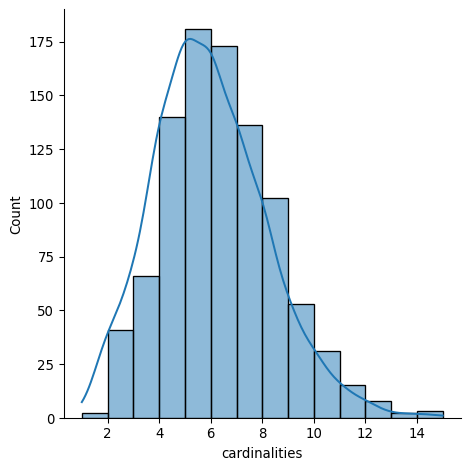

In [10]:
sns.displot(queen.cardinalities, bins=14, kde=True)

The figure above shows how most observations have around five
neighbours, but there is some variation around it. The distribution also
seems to follow nearly a symmetric form, where deviations from the
average occur both in higher and lower values almost evenly, with a
minor tail towards higher values.

Some additional information about the spatial relationships contained in
the matrix is also easily available from a `Graph` object. You can ask
about the number of observations (geometries) encoded in the graph:

In [11]:
queen.n

953

Or learn which geometries are *isolates*, the observations with no
neighbours (think about islands).

In [12]:
queen.isolates


Index([], dtype='object', name='focal')

Spatial weight matrices can be explored visually in other ways. For
example, you can pick an observation and visualise it in the context of
its neighbourhood. The following plot does exactly that by zooming into
the surroundings of ZSJ `Albertov` and displaying its polygon as well as
those of its neighbours:

In [13]:
m = prague.loc[queen['Albertov'].index].explore(color="#25b497")
prague.loc[['Albertov']].explore(m=m, color="#fa94a5")

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_f3b56a4d680a2d21d256c380335b85ed {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_f3b56a4d680a2d21d256c380335b85ed" ></div>
 
</body>
<script>
 
 
 var map_f3b56a4d680a2d21d256c380335b85ed = L.map(
 "map_f3b56a4d680a2d21d256c380335b85ed",
 {
 center: [50.07265577193773, 14.422660988119087],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_f3b56a4d680a2d21d256c380335b85ed);

 

 
 
 var tile_layer_3eee1241152e54030ea6d0e7a7564b42 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_f3b56a4d680a2d21d256c380335b85ed);
 
 
 map_f3b56a4d680a2d21d256c380335b85ed.fitBounds(
 [[50.0610467279152, 14.410961623091284], [50.084264815960275, 14.434360353146891]],
 {}
 );
 
 
 function geo_json_7411caa57ce1dd2ba5694f3c619c7f99_styler(feature) {
 switch(feature.id) {
 default:
 return {"color": "#25b497", "fillColor": "#25b497", "fillOpacity": 0.5, "weight": 2};
 }
 }
 function geo_json_7411caa57ce1dd2ba5694f3c619c7f99_highlighter(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.75};
 }
 }
 function geo_json_7411caa57ce1dd2ba5694f3c619c7f99_pointToLayer(feature, latlng) {
 var opts = {"bubblingMouseEvents": true, "color": "#3388ff", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#3388ff", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 2, "stroke": true, "weight": 3};
 
 let style = geo_json_7411caa57ce1dd2ba5694f3c619c7

#### Rook

Rook contiguity is similar to and, in many ways, superseded by queen
contiguity. However, since it sometimes comes up in the literature, it
is useful to know about it. The main idea is the same: two observations
are neighbours if they share some of their boundary lines. However, in
the rook case, it is not enough to share only one point. It needs to be
at least a segment of their boundary. In most applied cases, these
differences usually boil down to how the geocoding was done, but in some
cases, such as when you use raster data or grids, this approach can
differ more substantively, and it thus makes more sense.

From a technical point of view, constructing a rook matrix is very
similar:

In [14]:
rook = graph.Graph.build_contiguity(prague, rook=True)

The output is of the same type as before, a `W` object that can be
queried and used in very much the same way as any other one.

### Distance

Distance-based matrices assign the weight to each pair of observations
as a function of how far from each other they are. How this is
translated into an actual weight varies across types and variants, but
they all share that the ultimate reason why two observations are
assigned some weight is due to the distance between them.

#### K-Nearest Neighbors

One approach to define weights is to take the distances between a given
observation and the rest of the set, rank them, and consider as
neighbours the $k$ closest ones. That is exactly what the $k$-nearest
neighbours (KNN) criterium does.

To calculate KNN weights, you can use a similar function as before and
derive them from a `GeoDataFrame`:

In [15]:
prague["centroid"] = prague.centroid
prague = prague.set_geometry("centroid")
knn5 = graph.Graph.build_knn(prague, k=5)


Note how you need to specify the number of nearest neighbours you want
to consider with the argument `k`. Since it is a polygon `GeoDataFrame`
that you are passing, you need to compute the centroids to derive
distances between observations. Alternatively, you can provide the
points in the form of an array, skipping this way the dependency of a
file on disk:

In [16]:
pts = pd.DataFrame(
    {"X": prague.geometry.x, "Y": prague.geometry.y}
).values
knn5_from_pts = graph.Graph.build_knn(pts, k=5)


#### Distance band

Another approach to building distance-based spatial weights matrices is
to draw a circle of certain radius and consider neighbour every
observation that falls within the circle. The technique has two main
variations: binary and continuous. In the former one, every neighbour is
given a weight of one, while in the second one, the weights can be
further tweaked by the distance to the observation of interest.

To compute binary distance matrices in `PySAL`, you can use the
following command:

In [17]:
dist1kmB = graph.Graph.build_distance_band(prague, 1000)

This creates a binary matrix that considers neighbors of an observation
every polygon whose centroid is closer than 1,000 metres (1 km) to the
centroid of such observation. Check, for example, the neighbourhood of
polygon `Albertov`:

In [18]:
dist1kmB['Albertov']

neighbor
Vodičkova                     1
Londýnská                     1
Štěpánský obvod-západ         1
Nad muzeem                    1
Folimanka-východ              1
Nuselské údolí                1
Vyšehrad                      1
Podskalí                      1
Zderaz                        1
U Čelakovského sadů           1
Štěpánský obvod-východ        1
Folimanka-západ               1
Nad Nuselským údolím          1
Na bělidle-nábřeží            1
Smíchovský pivovar-nábřeží    1
V Čelakovského sadech         1
Name: weight, dtype: int64

Note that the units in which you specify the distance directly depend on
the CRS in which the spatial data are projected, and this has nothing to
do with the weights building but it can affect it significantly. Recall
how you can check the CRS of a `GeoDataFrame`:

In [19]:
prague.crs

<Projected CRS: EPSG:5514>
Name: S-JTSK / Krovak East North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Czechia; Slovakia.
- bounds: (12.09, 47.73, 22.56, 51.06)
Coordinate Operation:
- name: Krovak East North (Greenwich)
- method: Krovak (North Orientated)
Datum: System of the Unified Trigonometrical Cadastral Network
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In this case, you can see the unit is expressed in metres (`m`). Hence
you set the threshold to 1,000 for a circle of 1km radius.

An extension of the weights above introduces further detail by assigning
different weights to different neighbours within the radius circle based
on how far they are from the observation of interest. For example, you
could think of assigning the inverse of the distance between
observations $i$ and $j$ as $w_{ij}$. This can be computed with the
following command:

In [20]:
dist1kmC = graph.Graph.build_distance_band(prague, 1000, binary=False)

/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/libpysal/graph/base.py:679: RuntimeWarning: divide by zero encountered in power
  kernel=lambda distances, alpha: np.power(distances, alpha),

In `dist1kmC`, every observation within the 1km circle is assigned a
weight equal to the inverse distance between the two:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

This way, the further apart $i$ and $j$ are from each other, the smaller
the weight $w_{ij}$ will be.

Contrast the binary neighbourhood with the continuous one for
`Albertov`:

In [21]:
dist1kmC['Albertov']

neighbor
Vodičkova                     0.001055
Londýnská                     0.001162
Štěpánský obvod-západ         0.002192
Nad muzeem                    0.001084
Folimanka-východ              0.001082
Nuselské údolí                0.001281
Vyšehrad                      0.001247
Podskalí                      0.001803
Zderaz                        0.001436
U Čelakovského sadů           0.001264
Štěpánský obvod-východ        0.002001
Folimanka-západ               0.001636
Nad Nuselským údolím          0.001183
Na bělidle-nábřeží            0.001158
Smíchovský pivovar-nábřeží    0.001000
V Čelakovského sadech         0.001121
Name: weight, dtype: float64

Following this logic of more detailed weights through distance, there is
a temptation to take it further and consider everyone else in the
dataset as a neighbor whose weight will then get modulated by the
distance effect shown above. However, although conceptually correct,
this approach is not always the most computationally or practical one.
Because of the nature of spatial weights matrices, particularly because
of the fact their size is $N$ by $N$, they can grow substantially large.
A way to cope with this problem is by making sure they remain fairly
*sparse* (with many zeros). Sparsity is typically ensured in the case of
contiguity or KNN by construction but, with inverse distance, it needs
to be imposed as, otherwise, the matrix could be potentially entirely
dense (no zero values other than the diagonal). In practical terms, what
is usually done is to impose a distance threshold beyond which no weight
is assigned and interaction is assumed to be non-existent. Beyond being
computationally feasible and scalable, results from this approach
usually do not differ much from a fully “dense” one as the additional
information that is included from further observations is almost ignored
due to the small weight they receive. In this context, a commonly used
threshold, although not always best, is that which makes every
observation to have at least one neighbor.

> **Computing threshold**
>
> Such a threshold can be calculated using the `min_threshold_distance`
> function from `libpysal.weights` module:
>
> ``` python
> from libpysal import weights
>
> min_thr = weights.min_threshold_distance(pts)
> min_thr
> ```
>
>     1920.0404365049942
>
> Which can then be used to calculate an inverse distance weights
> matrix:
>
> ``` py
> min_dist = graph.Graph.build_distance_band(prague, min_thr, binary=False)
> ```

### Block weights

Block weights connect every observation in a dataset that belongs to the
same category in a list provided ex-ante. Usually, this list will have
some relation to geography and the location of the observations but,
technically speaking, all one needs to create block weights is a list of
memberships. In this class of weights, neighbouring observations, those
in the same group, are assigned a weight of one, and the rest receive a
weight of zero.

In this example, you will build a spatial weights matrix that connects
every ZSJ with all the other ones in the same KU. See how the KU code is
expressed for every ZSJ:

In [23]:
prague.head()

To build a block spatial weights matrix that connects as neighbours all
the ZSJ in the same KU, you only require the mapping of codes. Using
`PySAL`, this is a one-line task:

In [24]:
block = graph.Graph.build_block_contiguity(prague['NAZ_KU'])

If you query for the neighbors of observation by its name, it will work
as usual:

In [25]:
block['Albertov']

neighbor
Petrský obvod                 1
Masarykovo nádraží            1
Jindřišský obvod              1
Vodičkova                     1
Vojtěšský obvod               1
Štěpánský obvod-západ         1
Podskalí                      1
Zderaz                        1
Autobusové nádraží Florenc    1
U Čelakovského sadů           1
Štěpánský obvod-východ        1
V Čelakovského sadech         1
Masarykovo nádraží-východ     1
Name: weight, dtype: int64

## Standardizing `Graph` relationships

In the context of many spatial analysis techniques, a spatial weights
matrix with raw values (e.g. ones and zeros for the binary case) is not
always the best-suiting one for analysis and some sort of transformation
is required. This implies modifying each weight so they conform to
certain rules. `PySAL` has transformations baked right into the `Graph`
object, so it is possible to check the state of an object as well as to
modify it.

Consider the original queen weights for observation `Albertov`:

In [26]:
queen['Albertov']

neighbor
Vodičkova                 1
Vojtěšský obvod           1
Štěpánský obvod-západ     1
Nuselské údolí            1
Vyšehrad                  1
Podskalí                  1
Zderaz                    1
Štěpánský obvod-východ    1
Folimanka-západ           1
Name: weight, dtype: int64

Since it is contiguity, every neighbour gets one, the rest zero weight.
You can check if the object `queen` has been transformed or not by
calling the property `.transformation`:

In [27]:
queen.transformation

'O'

where `"O"` stands for “original”, so no transformations have been
applied yet. If you want to apply a row-based transformation so every
row of the matrix sums up to one, you use the `.transform()` method as
follows:

In [28]:
row_wise_queen = queen.transform("R")


Now you can check the weights of the same observation as above and find
they have been modified:

In [29]:
row_wise_queen['Albertov']

neighbor
Vodičkova                 0.111111
Vojtěšský obvod           0.111111
Štěpánský obvod-západ     0.111111
Nuselské údolí            0.111111
Vyšehrad                  0.111111
Podskalí                  0.111111
Zderaz                    0.111111
Štěpánský obvod-východ    0.111111
Folimanka-západ           0.111111
Name: weight, dtype: float64

The sum of weights for all the neighbours is one:

In [30]:
row_wise_queen['Albertov'].sum()

1.0

`PySAL` currently supports the following transformations:

-   `O`: original, returning the object to the initial state.
-   `B`: binary, with every neighbour having assigned a weight of one.
-   `R`: row, with all the neighbours of a given observation adding up
    to one.
-   `V`: variance stabilising, with the sum of all the weights being
    constrained to the number of observations.
-   `D`: double, with all the weights across all observations adding up
    to one.

## Reading and Writing spatial weights in `PySAL`

Sometimes, suppose a dataset is very detailed or large. In that case, it
can be costly to build the spatial weights matrix of a given geography,
and, despite the optimisations in the `PySAL` code, the computation time
can quickly grow out of hand. In these contexts, it is useful not to
have to rebuild a matrix from scratch every time you need to re-run the
analysis. A useful solution, in this case, is to build the matrix once
and save it to a file where it can be reloaded at a later stage if
needed.

`PySAL` has a way to efficiently write any kind of `Graph` object into a
file using the method `.to_parquet()`. This will serialise the
underlying adjacency table into an Apache Parquet file format that is
very fast to read and write and can be compressed to a small size.

In [31]:
queen.to_parquet("queen.parquet")

You can then read such a file back to the `Graph` from using
`graph.read_parquet()` function:

In [32]:
queen_2 = graph.read_parquet("queen.parquet")

> **Interoperabilty with other tools**
>
> Weights saved as a Parquet file are efficient if PySAL is the only
> tool you want to use to read and write them. If you want to save them
> to other file formats like GAL or GWT that are readable by tools like
> GeoDa, check the
> [documentation](https://pysal.org/libpysal/api.html#io) of the
> `libpysal.io` module.

## Spatial Lag

One of the most direct applications of spatial weight matrices is the
so-called *spatial lag*. The spatial lag of a given variable is the
product of a spatial weight matrix and the variable itself:

$$
Y_{sl} = W Y
$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that
the product of a matrix and a vector equals the sum of a row by column
element multiplication for the resulting value of a given row. In terms
of the spatial lag:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

If you are using row-standardized weights, $w_{ij}$ becomes a proportion
between zero and one, and $y_{sl-i}$ can be seen as the average value of
$Y$ in the neighborhood of $i$.

For this illustration, you will use the area of each polygon as the
variable of interest. And to make things a bit nicer later on, you will
keep the log of the area instead of the raw measurement. Hence, let’s
create a column for it:

In [33]:
prague = prague.set_geometry("geometry")
prague["area"] = np.log(prague.area)


The spatial lag is a key element of many spatial analysis techniques, as
you will see later on and, as such, it is fully supported in `PySAL`. To
compute the spatial lag of a given variable, `area`, for example:

In [34]:
queen_score = row_wise_queen.lag(prague["area"])
queen_score[:5]


array([13.84202483, 14.06442931, 13.83427974, 14.19385395, 14.10275008])

Line 4 contains the actual computation, which is highly optimised in
`PySAL`. Note that, despite passing in a `pd.Series` object, the output
is a `numpy` array. This however, can be added directly to the table
`prague`:

In [35]:
prague['w_area'] = queen_score

## Moran Plot

The Moran Plot is a graphical way to start exploring the concept of
spatial autocorrelation, and it is a good application of spatial weight
matrices and the spatial lag. In essence, it is a standard scatter plot
in which a given variable (`area`, for example) is plotted against *its
own* spatial lag. Usually, a fitted line is added to include more
information:

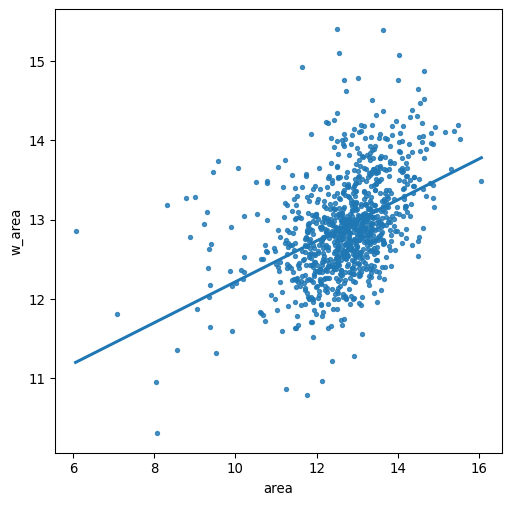

In [36]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x="area", y="w_area", data=prague, ci=None, ax=ax, marker=".");


In order to easily compare different scatter plots and spot outlier
observations, it is common practice to standardise the values of the
variable before computing its spatial lag and plotting it. This can be
accomplished by substracting the average value and dividing the result
by the standard deviation:

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the
average of the variable, and $\sigma$ its standard deviation.

Creating a standardised Moran Plot implies that average values are
centred in the plot (as they are zero when standardised), and dispersion
is expressed in standard deviations, with the rule of thumb of values
greater or smaller than two standard deviations being *outliers*. A
standardised Moran Plot also partitions the space into four quadrants
that represent different situations:

1.  High-High (*HH*): values above average surrounded by values above
    average.
2.  Low-Low (*LL*): values below average surrounded by values below
    average.
3.  High-Low (*HL*): values above average surrounded by values below
    average.
4.  Low-High (*LH*): values below average surrounded by values above
    average.

These will be further explored once spatial autocorrelation has been
properly introduced in subsequent blocks.

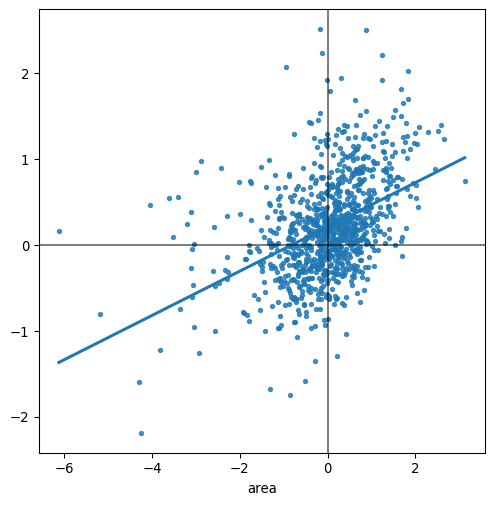

In [37]:
std_prague = (prague['area'] - prague['area'].mean()) / prague['area'].std()
std_w_prague = pd.Series(
    row_wise_queen.lag(std_prague), index=std_prague.index
)
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x=std_prague, y=std_w_prague, ci=None, marker=".")

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5);


## Acknowledgements

This section is derived from *A Course on Geographic Data Science* by
@darribas_gds_course, licensed under CC-BY-SA 4.0. The code was updated
to use the new `libpysal.graph` module instead of `libpysal.weights`.
The text was slightly adapted to accommodate a different dataset and the
module change.